## 훈련속도

앞서 모델을 생성하고, 모델은 어떻게 훈련하며, 그 과정에서 발생하는 그레디언트 이슈를 해결하는 방법에 대해 익혔습니다.

1차로 좋은 활성화 함수와 초기화 전략을 활용해 모델의 학습속도를 향상시킬 수 있음을 알았습니다.

신경망 모델을 훈련함에 있어서 훈련속도를 개선하기 위해 어떤 전략들을 활용할 수 있는지 알아보겠습니다.

### Tensorflow Dataset API

대용량 데이터를 다룰 때 굉장히 유용한 API입니다.

이에 대한 자세한 설명은 이 다음 장에서 이어가겠습니다.

이는 아래와 다른 기게적(기능적) 속도 향상에 도움이 되는 파트라 분리했습니다

### Transfer Training(전이학습)

우리가 채택할 수 있는 굉장히 좋은 전략입니다.

전이학습은 우리가 해결하려는 문제와 비슷한 유형의 문제를 처리한 신경망의 일부를 재사용하는 방법입니다.

아래와 같은 환경을 생각해보자.

In [47]:
from zipfile import ZipFile
import pandas as pd
import io
with ZipFile("../Data/고객 대출등급 분류 해커톤.zip","r") as f:
    data=io.BytesIO(f.read("고객 대출등급 분류 해커톤/train.csv"))
from sklearn import model_selection as mod
import numpy as np

data=pd.read_csv(data)

In [48]:
import keras

loaded_model=keras.models.load_model("Simple_Model.keras")

In [49]:
loaded_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,207 (207.84 KB)

 Trainable params: 17,735 (69.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,472 (138.57 KB)

위의 모델은 이전 장에서 학습완료한 모델입니다.

1차적으로 연석형 변수만 사용해 학습한 모델이였습니다.

또한 SELU를 사용하기 위해 연속형 데이터를 모두 정규화 시켰었습니다.

정규화 처리 층을 모델에 이식해주고 싶다면 다음과 같은 작업을 하면 되겠죠

In [50]:
cloned_model=keras.models.clone_model(loaded_model) # 모델 클로닝
# 모델 클로닝은 구조만 복사하기 떄문에 가중치를 업데이트 해줘야합니다

cloned_model.set_weights(loaded_model.get_weights())

위 방법의 장점은 `loaded_model`의 일부층을 사용하더라도 발생하는 영향을 배제할 수 있다는 것입니다.

만일 범주형 데이터까지 고려한 wide_deep model 에 위의 모델을 사용하고 싶다면,
(물론 selu의 자기정규성을 위한 조건에 맞지않아 성능이 떨어질 수 있습니다만)

다음과 같이 층을 분리해내면 됩니다.

(임베딩 layer를 채택하는게 좋은 상황이지만, 기본적으로 sklearn,pandas 에서 했던 방법을 최대한 유지하겠습니다)

In [55]:
import numpy as np

obj_col="대출목적"
num_col=data.select_dtypes(np.number).columns.to_list()

clone_layer=cloned_model.layers[:-1] #output layer 분리

for layer in clone_layer:
    layer.trainable=False

# trainable 을 False로 고정

In [56]:
stringlookup=keras.layers.StringLookup() # 텍스트 범주형 데이터 전처리
stringlookup.adapt(data[obj_col].values)

# 위를 기반으로 onehot encoding
category=keras.layers.CategoryEncoding(num_tokens=len(stringlookup.get_vocabulary()),
                                       output_mode="one_hot")

In [57]:
# 다음과 같이 one_hot encoding 됩니다
category(stringlookup(data[obj_col].values[:3]))

<tf.Tensor: shape=(3, 13), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [59]:
# selu 를 사용하기 위해 정규화
obj_normalization=keras.layers.Normalization()
obj_normalization.adapt(category(stringlookup(data[obj_col].values)))

normalization=keras.layers.Normalization()
normalization.adapt(data[num_col].values)

In [118]:
num_input=keras.Input(shape=(9,),name="연속형")
cate_input=keras.Input(shape=(13,),name="대출목적(범주형)")
inputs_saving=(num_input,cate_input)


num_pipe=keras.Sequential(clone_layer)
num_input=num_pipe(num_input)

initialize=keras.initializers.lecun_normal()

for _ in range(2):
    sub_layer=keras.layers.Dense(units=64,activation="selu",kernel_initializer=initialize)
    cate_input=sub_layer(cate_input)


concat=keras.layers.Concatenate()([num_input,cate_input])
outputs=keras.layers.Dense(7,activation="sigmoid",kernel_initializer=initialize)(concat)

New_model=keras.Model(inputs=inputs_saving,outputs=outputs)

In [119]:
optimizer=keras.optimizers.AdamW()
loss=keras.losses.SparseCategoricalCrossentropy()
metric_list=[keras.metrics.SparseCategoricalAccuracy()]

New_model.compile(optimizer=optimizer,loss=loss,metrics=metric_list)

In [120]:
num_cols=list(data.select_dtypes(np.number).columns)

use_feature=data[num_cols+[obj_col]]
label_list=data.대출등급.unique()
label_list.sort()

use_label=data.대출등급.map(lambda label : np.argmax(label_list==label))

train_feature,test_feature,train_label,test_label=mod.train_test_split(
    use_feature,use_label,train_size=0.9,stratify=use_label,random_state=1)

In [121]:
num_train=normalization(train_feature.loc[:,num_cols])
obj_train=obj_normalization(
    category(stringlookup(train_feature[obj_col].values))
)

num_test=normalization(test_feature.loc[:,num_cols])
obj_test=obj_normalization(
    category(stringlookup(test_feature[obj_col].values))
)

In [126]:
callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)]
New_model.fit(x=(num_train,obj_train),y=train_label.values,batch_size=16,epochs=5
              ,validation_data=((num_test,obj_test),test_label.values),
                 callbacks=callbacks)

Epoch 1/5
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - loss: 0.4173 - sparse_categorical_accuracy: 0.8461 - val_loss: 0.4135 - val_sparse_categorical_accuracy: 0.8497
Epoch 2/5
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.4049 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.4079 - val_sparse_categorical_accuracy: 0.8520
Epoch 3/5
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.4044 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.4062 - val_sparse_categorical_accuracy: 0.8498
Epoch 4/5
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.3975 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.3999 - val_sparse_categorical_accuracy: 0.8530
Epoch 5/5
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - loss: 0.4003 - sparse_categorical_accuracy: 0.8539 - val_loss: 0.3974 - val_sparse_categorical_accuracy: 0.8518


이후 위의 동결된 부분(`cloned layer`)의 `trainable=True`로 설정한 뒤 다시 재학습 시키면 됩니다.

이와 같은 전이학습은 비슷한 적업의 모델을 재사용함으로써 성능과 속도 모두 충족시키는 좋은 방법입니다.(예시를 위해 같은 데이터를 사용하였습니다)

__전이학습의 주의점__

> 전이학습은 작은 완전연결 네트워크에서 잘 작동하지 않습니다. (이는 특정패턴을 학습하는데 집중되기 때문입니다.)

> 따라서 일반적인 특성을 학습하는 심층 합성곱 신경망(특히 아래층)에서 잘 작동합니다



### 비지도 사전 학습

- 오토인코더 혹은 생성적 적대 신경망과 같은 비지도 학습 모델을 학습시킨 뒤 하위층을 활용

- 탐욕적 층 단위 사전훈련 기법

### 고속옵티마이저 

전통적(표준적으로 사용되는)인 경사하강 옵티마이저 대신 더 빠른 옵티마이저를 선택하는 것도 좋은 방법입니다.

이에 대한 설명은 굉장히 길고 복잡하므로 Tensorflow Dataset API 이후 설명하겠습니다

#### 학습률 스케줄링

우선 기본적이 설명은 표준적인 경사하강법을 사용해 설명하겠습니다.

좋은 학습률($\eta$)을 찾는 것은 굉장히 중요합니다.

작은 학습률은 수렴하기에 안정적이지만, 초기 훈련 속도를 증가시킵니다.

큰 학습률은 초기 훈련속도를 증가시킬 수 있지만, 수렴하지 못할 리스크를 증가시킵니다(심지어 지나치게 크면 발산할 수 있습니다)

이후 공부할 `Keras Tuner`를 통한 학습률 튜닝 방법은 그리드 서치와 유사한 방법으로,

작은 학습률에서 큰 학습률(혹은 역순)순으로 대입해가며 학습곡선을 보며, 좋은 학습률을 찾아냅니다.

위 전략보다 더 좋은 전략은 학습동안 학습률이 큰 값에서 작은 값으로 변화해가는 것입니다.

편의를 위해 반복횟수를 $t$, 학습률을 $\eta$ , 지정 스텝 수(step)를 $s$(하이퍼 파라미터)로 나타냅니다.

* 거듭제곱

    $\eta(t)=\eta_0/(1+t/s)^c$
    
    일반적으로 c=1 입니다(튜닝할 수 있습니다)

* __지수__

    $\eta(t)=\eta_0*(0.1)^{t/s}$

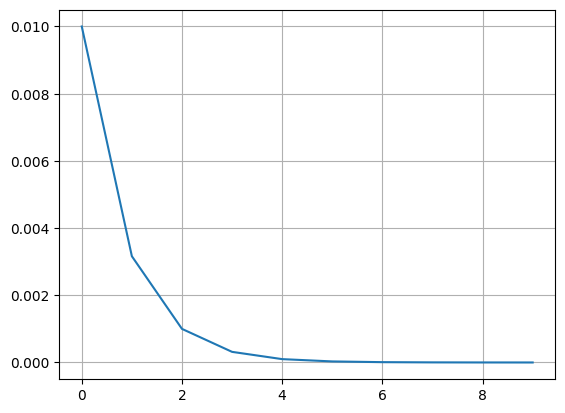

In [144]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as sts

epoch_t=range(0,10)
lr_0=0.01
s=2

def learninig_scheduler(lr_0,epoch):
    return lr_0*(0.1)**(epoch/s)

learing_rates=list(map(lambda epoch : learninig_scheduler(lr_0,epoch),epoch_t))
plt.plot(learing_rates)
plt.grid()

* 구간별 고정

    일정 횟수의 에포크동안 고정된 학습률을 사용하고, 다음 일정 횟수동안 보다 작은 학습률로 학습합니다.
    
    이는 횟수와 학습률의 조합을 튜닝해야해서 널리 사용되지 않습니다 

* 성능

    n 스텝마다 검증 오차를 측정하고, 오차가 줄어들지 않으면 $\lambda$ 만큼 $\eta$를 감소시킵니다

* __1사이클__

    - 1. 훈련 절반동안 초기 학습률 $\eta_0$를 선형적으로 $\eta_1$까지 증가시킵니다.
    - 2. 다음 절반동안 선형적으로 학습률을 $\eta_0$로 선형적으로 감소시킵니다.
    - 3. 남은 몇번의 에포크동안 학습률을 소수점 자리까지 선형적으로 감소시킵니다.
    
    >모멘텀은 위와 반대로 (감소)-(증가)-(최댓값유지) 로 진행됩니다(모멘텀 개념은 고속옵티마이저 설명에 추가하겠습니다)

주로 선호되는 지수기반, 1사이클 스케쥴링을 구현하고 사용해보죠.

In [146]:
# 1. learning_rate 직접 전달

lr_scheduler=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005,decay_steps=10,decay_rate=0.1)
sgd=keras.optimizers.SGD(learning_rate=lr_scheduler)

In [148]:
# 2. Callback 에 전달

def schedule_function(epoch,lr): # 에포크,초기 학습률 순으로 매개변수를 받을 수 있습니다
    return lr*(0.1)**(epoch/10) # decay_step,decay_rate 가 하드코딩되었습니다

lr_schedule_callback=keras.callbacks.LearningRateScheduler(schedule=schedule_function)

1Cycle Scheduler

- 전체 훈련을 1Cycle로 보는 기본버전
- 일부 훈련을 1Cycle을 사용하는 변형버전

두 가지를 고려해 데코레이터 함수를 만들겠습니다.

In [150]:
def onecycle(cycle_size,epochs,max_lr):
    # 일반적으로 초기 훈련량은 최적(혹은 최대) 훈련량의 1/10입니다
    cycle=int(epochs*cycle_size)
    sub_lr_step=max_lr*0.9/int(cycle/2)
    def lr_func(epoch,lr):
        if epoch<=cycle/2:
            return lr+sub_lr_step*epoch
        elif epoch> cycle:
            return lr
        else:
            return lr+sub_lr_step*(cycle-epoch)
    return lr_func

한번 테스트해보죠.

이전에 만든 모델을 수렴할때까지 훈련시켜보겠습니다.

In [226]:
cloned_model=keras.models.clone_model(loaded_model) # 모델 클로닝

In [232]:
optimizer=keras.optimizers.SGD(learning_rate=0.01)
loss=keras.losses.SparseCategoricalCrossentropy()
metric_list=[keras.metrics.SparseCategoricalAccuracy()]

cloned_model.compile(optimizer,loss,metrics=metric_list)

In [233]:
def closer_exp_lr(decay_rate,decay_step):
    def exp_lr(epoch,lr):
        return lr*(decay_rate)**(epoch/decay_step)
    return exp_lr
    
learing_rate_schedule=closer_exp_lr(0.1,10)

callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)]
lr_schedule=keras.callbacks.LearningRateScheduler(learing_rate_schedule)
callbacks.append(lr_schedule)

In [234]:
callbacks

In [ ]:
history=cloned_model.fit(x=num_train,y=train_label.values,batch_size=256,epochs=100
              ,validation_data=(num_test,test_label.values),
                 callbacks=callbacks)